# GPU-accelerated non-local means filter demonstrations
**Author**: Krittanon "Pond" Sirorattanakul (Caltech Seismological Laboratory)

**Email**: krittanon.pond@gmail.com

**Date**: June 2, 2021

This is a Jupyter notebook aiming to demonstrate how to use the GPU-accelerated numba non-local means filter code. This notebook can be run on Google Colab, a platform with free NVIDIA GPUs available for users. There are a selection of different GPU models available, but the model that you will get depends on availability.

## Required Python Libraries
* python 3
* numpy
* scipy
* matplotlib
* numba


## Setup related directories and libraries

In [1]:
# List information about NVIDIA GPU available
!nvidia-smi

Thu Jun  3 02:23:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Link google colab with google drive so that we can read/write the dataset 
# directly from our google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set the path to the folder that contains the dataset
import sys
datapath = '/content/drive/MyDrive/CS179/NL-means/'
sys.path.insert(1, datapath)

In [4]:
# Import necessary libraries
# The usual libraries
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import scipy.io as sio            
import time                       
import warnings
warnings.filterwarnings('ignore')

# Import NL-means library (numba is required to run these functions)
from NLmeans import NLmeans,NLmeans_jit,NLmeans_GPU

In [5]:
# Help Google Colab locates related CUDA file
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

## Load sample data

In [6]:
# FN_fil_matlab is filtered version of FN using a Matlab non-local means filter 
# to be used to check the accuracy of the python code.

# Load the data
data = sio.loadmat(datapath + "NLmeans_test_data.mat")
FN = data["FN"]
FN_fil_matlab = data["FN_fil"]

# Specify filtering paramters similar to the one used by Matlab
f = 3     # radius of similarity window
t = 41    # radius of search window
h = 0.5   # half-amplitude of noise

##Python native

In [7]:
# Running python native code
start = time.time()
output = NLmeans(FN,f,t,h)
end = time.time()
print("Elapsed (python native) = %s seconds" % (end - start))

Elapsed (python native) = 691.8001384735107 seconds


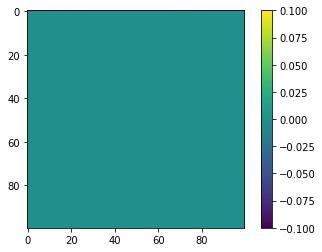

In [8]:
# Compare with the expected results from Matlab
plt.imshow(output-FN_fil_matlab)
plt.colorbar()
plt.show()

##Python numba jit

In [9]:
# Running python code with jit
start = time.time()
out = NLmeans_jit(FN,f,t,h)
end = time.time()
print("Elapsed (numba with compilation) = %s seconds" % (end - start))

Elapsed (numba with compilation) = 16.749077558517456 seconds


In [10]:
del output
start = time.time()
output = NLmeans_jit(FN,f,t,h)
end = time.time()
print("Elapsed (numba after compilation) = %s seconds" % (end - start))

Elapsed (numba after compilation) = 14.17966079711914 seconds


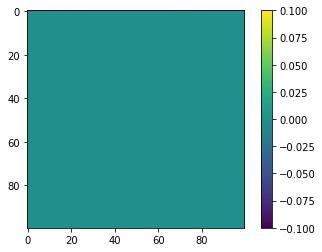

In [11]:
# Compare with the expected results from Matlab
plt.imshow(output-FN_fil_matlab)
plt.colorbar()
plt.show()

## GPU-accelerated with CUDA kernels

In [12]:
blocks = (10,10)
threads_per_block = (10,10)
start = time.time()
output = NLmeans_GPU(FN,f,t,h,blocks,threads_per_block)
end = time.time()
print("Elapsed (numba with compilation) = %s seconds" % (end - start))

Elapsed (numba with compilation) = 1.2154147624969482 seconds


In [13]:
del output
start = time.time()
output = NLmeans_GPU(FN,f,t,h,blocks,threads_per_block)
end = time.time()
print("Elapsed (numba after compilation) = %s seconds" % (end - start))

Elapsed (numba after compilation) = 0.19620752334594727 seconds


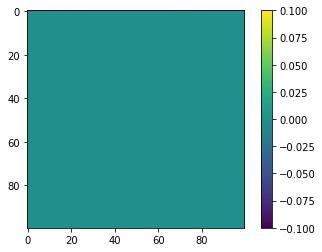

In [14]:
# Compare with the expected results from Matlab
plt.imshow(output-FN_fil_matlab)
plt.colorbar()
plt.show()